# Convolutional Neural Networks for Image Classification

In this notebook, I will utilize deep learning models to classify handwritten digits. I will use the MNIST dataset where the digits are sized 28x28.
I'll compare the accuracy achieved by a multilayer perceptron and a convolutional neural network. For the convolutional neural network, I'll compute the size of the input and output at each convolutional layer based on the parameters of each layer (kernel size, padding, stride, etc.) to ensure that the tensors flowing through the network are of the appropriate size. I will also indicate the size of the feature maps as they flow through the network.

To begin, I'll start by loading and visualizing the dataset.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:04<00:00, 2333867.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 349075.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3186449.08it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8844256.62it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


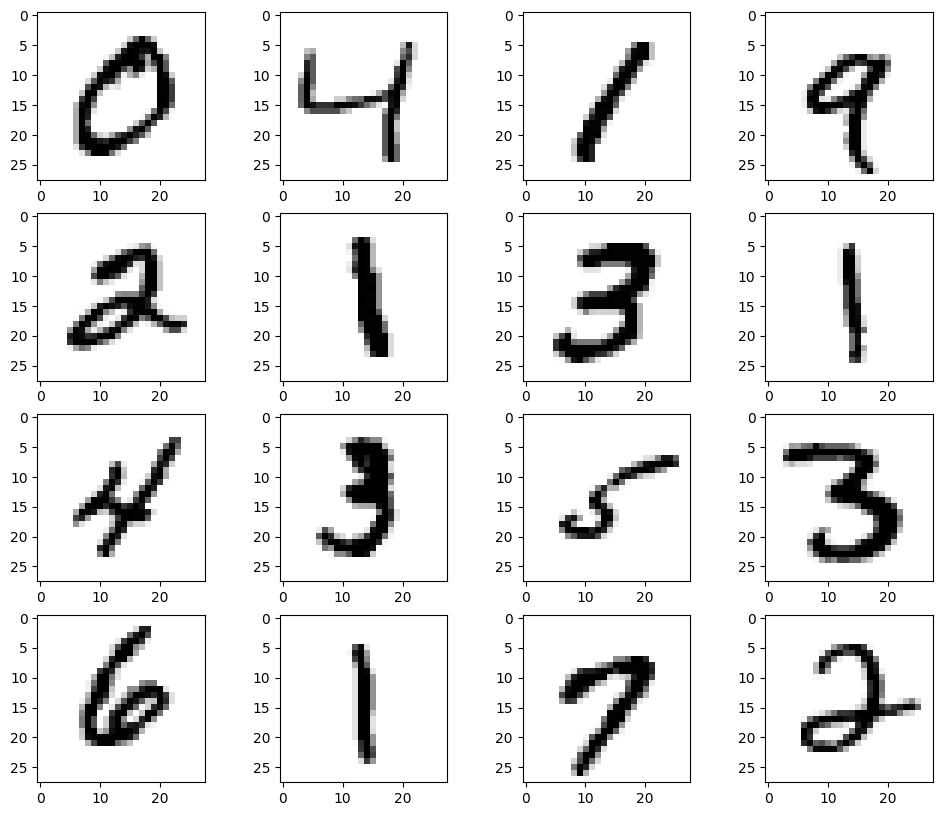

In [1]:
import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [12, 10]

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())


for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(mnist_train.train_data[i,:,:], cmap=plt.get_cmap('gray_r'))


# Multilayer Perceptron



First, I will use a multilayer perceptron to classify images of 28 x 28 into 10 different categories. To achieve this, I need to make some changes:

Before processing the image, I will reformat it to convert it from a 28 x 28 image to a vector of 784 components. To do this, I will use the view method of PyTorch tensors.

I will use a perceptron with 15 neurons in the hidden layers.

The last layer should have 10 neurons (instead of just 1 as the multilayer perceptron that can be used for regression).

In this case, I will use Cross Entropy Loss (torch.nn.CrossEntropyLoss) as the loss function.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class NetMLP(torch.nn.Module):
    def __init__(self, input_features, size_hidden, n_output):
        super(NetMLP, self).__init__()
        self.hidden1 = nn.Linear(input_features, size_hidden)
        self.hidden2 = nn.Linear(size_hidden, size_hidden)
        self.out = nn.Linear(size_hidden, n_output)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)        # linear output
        return x

In [3]:
# to verify that the view conversion is working
mnist_train.train_data[1,:,:].view(-1,28*28).shape

torch.Size([1, 784])

Epoch 0, loss = 0.652654
Epoch 1, loss = 0.448066
Epoch 2, loss = 0.616583
Epoch 3, loss = 0.556619
Epoch 4, loss = 0.387404


Text(0.5, 1.0, 'Loss Function During Training')

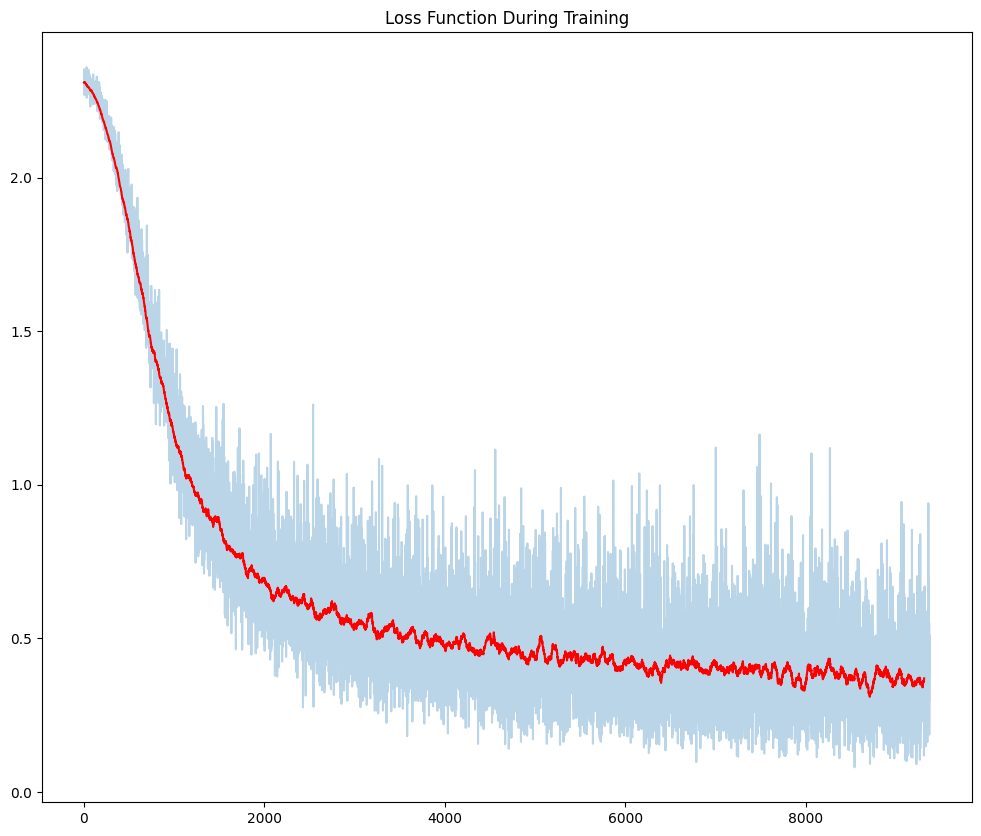

In [4]:
# Defining the perceptron model
input_features = 28*28
hidden_neurons = 15
num_outputs = 10 # because we want to predict 10 diferent numbers

# Training batch size
batch_size = 50

# Initial learning rate for gradient descent
learning_rate = 0.0001

# Device to run the model: 'cuda:0' for GPU and 'cpu' for CPU
device = torch.device('cuda:0')

net = NetMLP(input_features, hidden_neurons, num_outputs)
net.to(device)

# Building the optimizer, specifying the parameters to optimize
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Defining the loss function to use
criterion = nn.CrossEntropyLoss()

# Creating an iterable loader to read data from the dataset created earlier.
# This object can be iterated over and returns one batch (x, y) at a time.
loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)

# Number of epochs
num_epochs = 5

# List to store the value of the loss function at each training stage
loss_list = []

# Training loop
for i in range(num_epochs):

    # Iterating over all batches in the dataset
    for x, y in loader:
        # Setting gradients of parameters to optimize to zero
        optimizer.zero_grad()

        # Moving tensors to GPU memory
        x = x.to(device)
        y = y.to(device)

        # Performing forward pass through the network
        loss = criterion(net(x), y)

        # Performing backward pass through the network
        loss.backward()

        # Updating network weights with the optimizer
        optimizer.step()

        # Saving the current value of the loss function for later plotting
        loss_list.append(loss.data.item())

    # Displaying the value of the loss function at each epoch
    print('Epoch %d, loss = %g' % (i, loss))

# Displaying the list containing the values of the loss function
# and a smoothed version (in red) to observe the trend
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha=0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Loss Function During Training")


In [6]:
# We can save the model for future if needed in order to reuse it
torch.save(net.state_dict(), "./mlp20.pth")

In [7]:
# I will load the saved model, I will use the classification_report and confusion_matrix methods from scikit-learn.
# (if the model is already in memory, this step is not necessary)
input_features = 28*28
hidden_neurons = 15
num_outputs = 10
net = NetMLP(input_features,hidden_neurons,num_outputs)
net.load_state_dict(torch.load("./mlp20.pth"))
net.to(device)

NetMLP(
  (hidden1): Linear(in_features=784, out_features=15, bias=True)
  (hidden2): Linear(in_features=15, out_features=15, bias=True)
  (out): Linear(in_features=15, out_features=10, bias=True)
)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.94      0.97      0.95      1135
           2       0.92      0.88      0.90      1032
           3       0.89      0.88      0.88      1010
           4       0.91      0.91      0.91       982
           5       0.88      0.83      0.85       892
           6       0.93      0.93      0.93       958
           7       0.91      0.90      0.90      1028
           8       0.85      0.86      0.85       974
           9       0.86      0.89      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



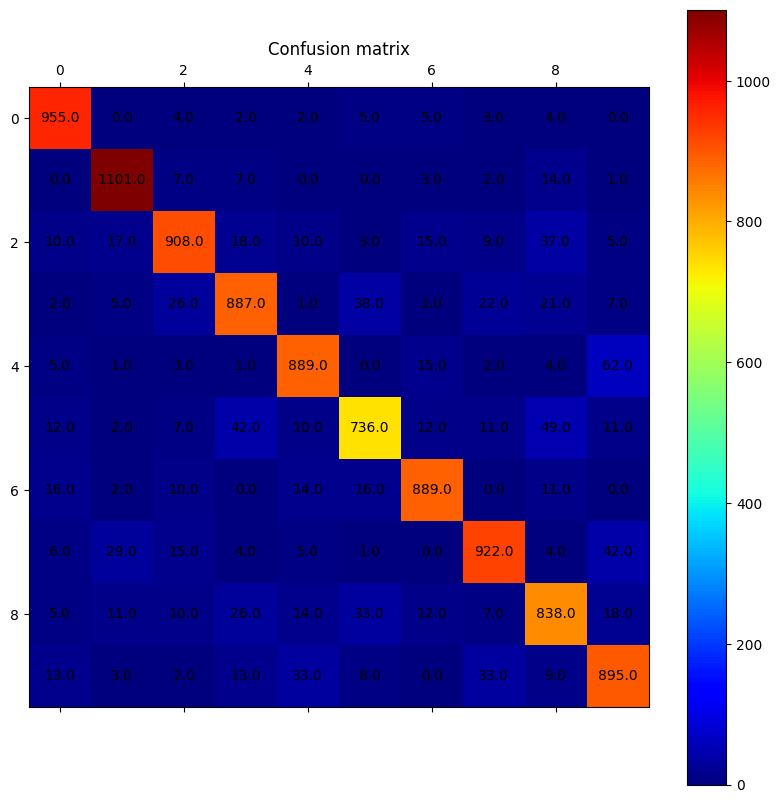

In [8]:
def showTestResults(model):
  plt.rcParams['figure.figsize'] = [12, 10]
  from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

  # Generating a data loader to read the test data
  loader_test = DataLoader(dataset=mnist_test, batch_size=10000, shuffle=False)
  x_test = list(loader_test)[0][0]
  y_test = list(loader_test)[0][1]

  # Moving tensors to the GPU
  x_test = x_test.to(device)

  # Making predictions using the model
  pred = model(x_test)

  # Extracting the index of the prediction with the highest value to determine the assigned class
  pred_y = torch.max(pred.to("cpu"), 1)[1].data.numpy()

  # Printing the classification report (accuracy, etc.)
  print(classification_report(y_test, pred_y))

  # Computing the confusion matrix and displaying it
  conf_mat = confusion_matrix(y_test, pred_y)
  plt.matshow(conf_mat, cmap='jet')

  for (i, j), z in np.ndenumerate(conf_mat):
      plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

  plt.title("Confusion matrix")
  plt.colorbar()

showTestResults(net)


0.9 accuracy, let's see if a convolutional neural network can perform better than that.

# Convolutional Neural Network



Now I will define a NetCNN model that implements a convolutional neural network, which will follow the following structure:
* Convolutional layer (`nn.Conv2D`) (6 output feature maps) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Convolutional layer (nn.Conv2D) (16 output feature maps) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Fully connected layer (`nn.Linear`) (120 neurons) + ReLU
* Fully connected layer (`nn.Linear`) (84 neurons) + ReLU
* Output layer (`nn.Linear`) (10 neurons)

Note that we will use the `CrossEntropyLoss` function to train the model. Remember that given:
* F: filter size
* W: Size of the input feature map
* P: Padding
* S: Stride

The size of the output is  $O = \frac{(W - F + 2P)}{S} + 1$


In [9]:
class NetCNN(nn.Module):

    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Convolutional layer 1 + ReLU + Max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        # Convolutional layer 2 + ReLU + Max pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        # When transitioning from a convolutional layer to a fully connected layer, we need
        # to reshape the output to become a one-dimensional vector
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 0, loss = 0.186752
Epoch 1, loss = 0.110188
Epoch 2, loss = 0.370866
Epoch 3, loss = 0.15453
Epoch 4, loss = 0.10459


Text(0.5, 1.0, 'Loss Function During Training')

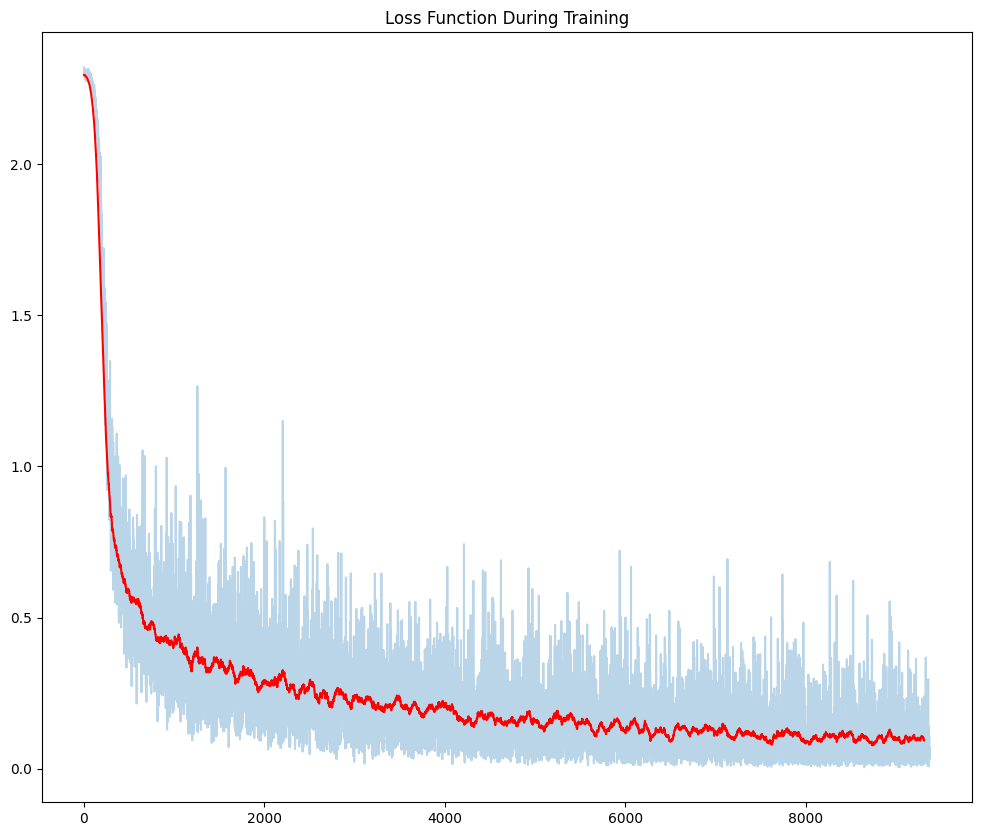

In [11]:
# Training batch size
batch_size = 50

# Initial learning rate for gradient descent
learning_rate = 0.0001

# Device to run the model: 'cuda:0' for GPU and 'cpu' for CPU
device = torch.device('cuda:0')

net = NetCNN() # using the convolutional neural network
net.to(device)

# Building the optimizer, specifying the parameters to optimize
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Defining the loss function to use
criterion = nn.CrossEntropyLoss()

# Creating an iterable loader to read data from the dataset created earlier.
# This object can be iterated over and returns one batch (x, y) at a time.
loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)

# Number of epochs
num_epochs = 5

# List to store the value of the loss function at each training stage
loss_list = []

# Training loop
for i in range(num_epochs):

    # Iterating over all batches in the dataset
    for x, y in loader:
        # Setting gradients of parameters to optimize to zero
        optimizer.zero_grad()

        # Moving tensors to GPU memory
        x = x.to(device)
        y = y.to(device)

        # Performing forward pass through the network
        loss = criterion(net(x), y)

        # Performing backward pass through the network
        loss.backward()

        # Updating network weights with the optimizer
        optimizer.step()

        # Saving the current value of the loss function for later plotting
        loss_list.append(loss.data.item())

    # Displaying the value of the loss function at each epoch
    print('Epoch %d, loss = %g' % (i, loss))

# Displaying the list containing the values of the loss function
# and a smoothed version (in red) to observe the trend
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha=0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Loss Function During Training")

In [12]:
# We can save the model for future if needed in order to reuse it
torch.save(net.state_dict(), "./cnn20.pth")

In [13]:
# I will load the saved model, I will use the classification_report and confusion_matrix methods from scikit-learn.
# (if the model is already in memory, this step is not necessary)
net = NetCNN()
net.load_state_dict(torch.load("./cnn20.pth"))
net.to(device)

NetCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.96      0.98      0.97      1010
           4       0.96      0.99      0.97       982
           5       1.00      0.94      0.97       892
           6       0.99      0.98      0.98       958
           7       0.98      0.95      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



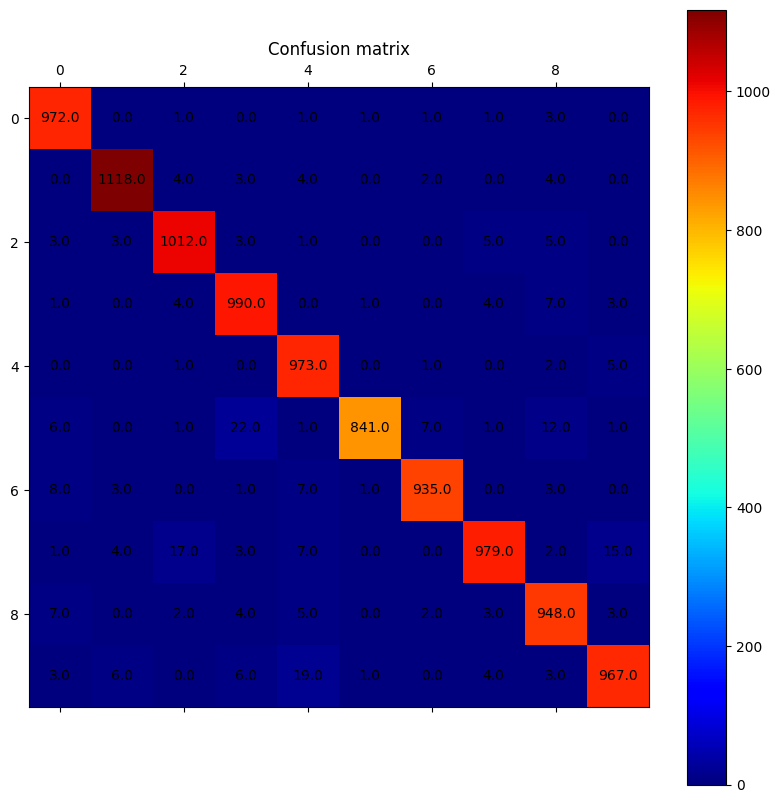

In [14]:
# showing the results:
showTestResults(net)

We have reached a 0.97 accuracy with the Convolutional Neural Network as expected.

# Analyzing the Convolutional Neural Network




Now I am going to calculate the size of the input and output at each convolutional layer based on the parameters of each layer (kernel size, padding, stride, etc.) to ensure that the tensors flowing through the network are of the appropriate size. I will also indicate the size of the feature maps as they flow through the network.

Remembering the function:
* F: filter size
* W: Size of the input feature map
* P: Padding
* S: Stride

The size of the output is  $O = \frac{(W - F + 2P)}{S} + 1$

**Convolutional layer 1 (conv1):**

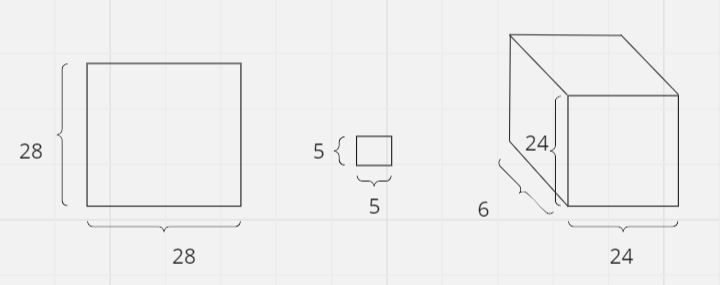

* F: 5
* W: 28
* P: 0
* S: 1
* Number of output feature maps: 6

The size of the output is $O = \frac{(28 - 5 + 2*0)}{1} + 1$ = 24


The size of the output feature map: 6 x 24 x 24

**Max pooling 2 x 2:**

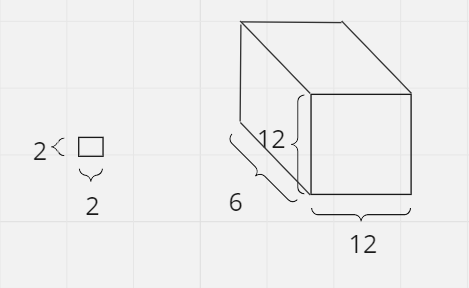


* Reduce the size of the feature map by half..

The size of the output feature map: 6 x 12 x 12


**Capa convolucional 2 (conv2):**

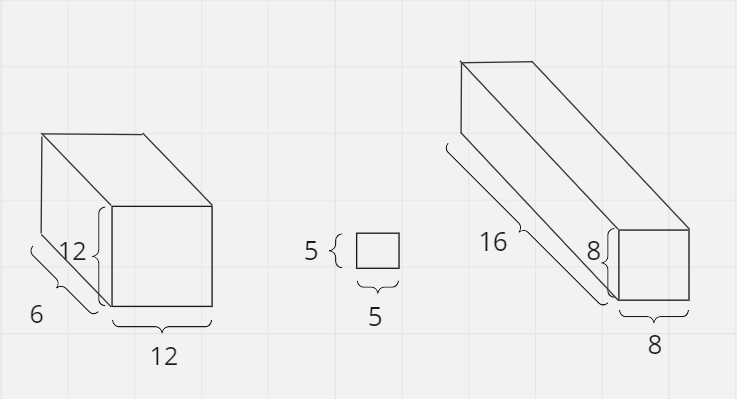


* F: 5
* W: 12
* P: 0
* S: 1
* Number of output feature maps: 16

The size of the output is $O = \frac{(12 - 5 + 2*0)}{1} + 1$ = 8


The size of the output feature map: 16 x 8 x 8

**Max pooling 2 x 2:**

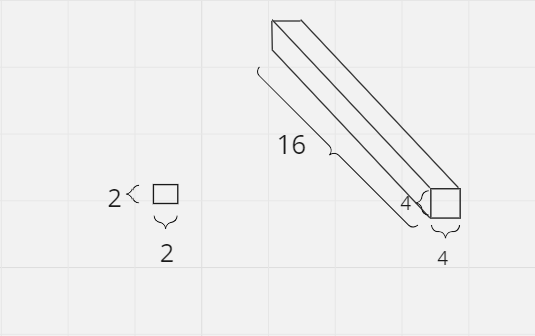

* Reduce the size of the feature map by half...

The size of the output feature map: 16 x 4 x 4

# Comparing (MLP) and (CNN) Accuracy

In [15]:
# Loading the multilayer perceptron model (MLP)
input_features = 28 * 28
hidden_neurons = 15
num_outputs = 10
net_mlp = NetMLP(input_features, hidden_neurons, num_outputs)
net_mlp.load_state_dict(torch.load("./mlp20.pth"))
net_mlp.to(device)

# Loading the convolutional neural network (CNN) model
net_cnn = NetCNN()
net_cnn.load_state_dict(torch.load("./cnn20.pth"))
net_cnn.to(device)

# Setting the test batch size equal to the total number of records
batch_size = 10000

# Creating a DataLoader for the test dataset
loader_test = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False)

# Generating a function to calculate the accuracy on the test set
def calculate_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader_test:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Calculating the accuracy of the multilayer perceptron model (MLP)
mlp_accuracy = calculate_accuracy(net_mlp)
print("Accuracy of the Multilayer Perceptron on test: {:.2f}%".format(mlp_accuracy))

# Calculating the accuracy of the convolutional neural network (CNN)
cnn_accuracy = calculate_accuracy(net_cnn)
print("Accuracy of the Convolutional Neural Network on test: {:.2f}%".format(cnn_accuracy))


Accuracy of the Multilayer Perceptron on test: 90.20%
Accuracy of the Convolutional Neural Network on test: 97.35%


Convolutional Neural Networks (CNNs) outperform Multilayer Perceptrons (MLPs) in image classification tasks because of:

  - ***Hierarchical Feature Extraction*:** CNNs can learn and recognize complex and hierarchical patterns in images, such as edges, textures, and shapes, thanks to their convolutional layers, while MLPs lack this specialized capability.

  - ***Spatial Invariance and Robustness:*** CNNs are inherently more robust to translations and distortions in images due to filter sharing and local convolutional operations, making them ideal for processing visual data.

  - ***Dimensionality Reduction:*** Pooling layers in CNNs allow for reducing the dimensionality of the data, preventing overfitting, whereas MLPs may be more prone to this phenomenon in complex and large datasets.

-- THE END -- THANK YOU !